## 1. Get data

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
voc_dir = "/Users/macbook/Documents/WorkSpace/FCN-for-semantic-segmantation/data/VOCdevkit/VOC2012"

def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)
print(f'# training images: {len(train_features)}')


# training images: 1464


array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

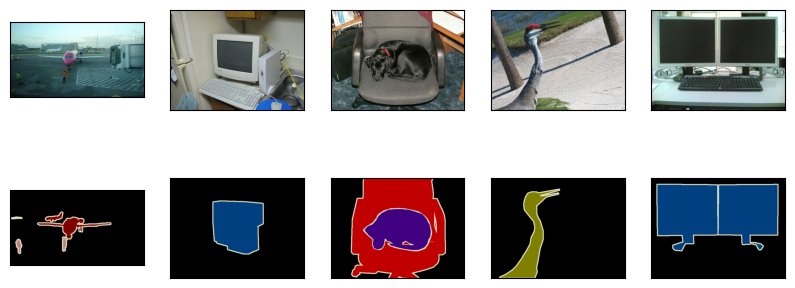

In [3]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]

# Generate a function to visualize 5 images
def show_images(imgs, num_rows, num_cols, scale=2):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].permute(1, 2, 0))
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

show_images(imgs, 2, n, scale=2)

In [4]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [5]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

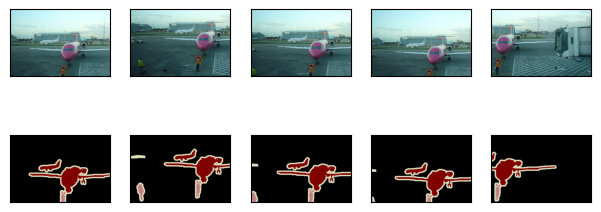

In [6]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

show_images(imgs[::2] + imgs[1::2], 2, n, scale=1.5)

In [7]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

## Reading the Dataset

In [8]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [9]:
voc_train[0][0].shape, voc_train[0][1].shape

(torch.Size([3, 320, 480]), torch.Size([320, 480]))

In [10]:
# %%writefile data_setup.py

import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

NUM_WORKERS = 0 

#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

def create_dataloader(voc_dir, batch_size, crop_size):
    num_workers = NUM_WORKERS
    train_iter = DataLoader(VOCSegDataset(True, crop_size, voc_dir),
                            batch_size, shuffle=True,
                            drop_last=True, num_workers=num_workers)
    test_iter = DataLoader(VOCSegDataset(False, crop_size, voc_dir),
                           batch_size, drop_last=True, num_workers=num_workers)
    return train_iter, test_iter



In [11]:
batch_size = 64
crop_size = (320, 480)
train_iter, test_iter = create_dataloader(voc_dir, batch_size, crop_size)
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

read 1114 examples
read 1078 examples
torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


## Summary for data
Semantic segmentation recognizes and understands what are in an image in pixel level by dividing the image into regions belonging to different semantic classes.

One of the most important semantic segmentation dataset is Pascal VOC2012.

In semantic segmentation, since the input image and label correspond one-to-one on the pixel, the input image is randomly cropped to a fixed shape rather than rescaled.

## Model


In [12]:
# %%writefile model.py
import torch.nn as nn
import torchvision.models as models

class FCN_Resnet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pre-trained Resnet18 model
        self.resnet = models.resnet18(pretrained=True)

        # Remove the last 2 layers (avgpool and fc)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # Add a 1x1 convolutional layer
        self.conv1x1 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        # Add a transposed convolutional layer
        self.transposed_conv = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32)

    def forward(self, x):
        x = self.resnet(x)
        x = self.conv1x1(x)
        x = self.transposed_conv(x)
        return x


In [13]:
import torch 
import torchvision
from torch import nn
from torch.nn import functional as F 

# The last few layers of this model include a 
# global average pooling layer and a fully connected layer: they are not needed in the fully convolutional network.

pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:] # Show 3 last layers of the model

/Users/macbook/anaconda3/envs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/macbook/anaconda3/envs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [14]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [15]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [16]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [17]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [18]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0

In [19]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [20]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = create_dataloader(voc_dir, batch_size, crop_size)

read 1114 examples
read 1078 examples


## Training

In [24]:
from tqdm import tqdm
import torch

def accuracy(y_hat, y):
    """Compute number of correct predictions"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp = (y_hat.type(y.dtype) == y).type(y.dtype)
    return float(torch.sum(cmp))



def loss_fn(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, torch.device("cpu")

optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

def train_epoch(net, train_iter, test_iter, loss_fn, optimizer, num_epochs, devices):# test_iter,
    net = net.to(devices)
    for epoch in range(num_epochs):
        net.train()
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0

        for batch, (X, y) in tqdm(enumerate(train_iter)):

            #Send data to device
            X, y = X.to(devices), y.to(devices)

            #Forward pass
            y_pred = net(X)

            #Compute loss
            loss = loss_fn(y_pred, y)

            #Optimizer zero
            optimizer.zero_grad()

            #Backward pass
            loss.sum().backward()

            #Optimize step
            optimizer.step()

            train_loss_sum += loss.sum()
            train_acc_sum += accuracy(y_pred, y)
            n += y.numel()


        # Testing 
        net.eval()
        test_loss_sum, test_acc_sum, m = 0.0, 0.0, 0
        with torch.inference_mode():
            for batch, (X, y) in tqdm(enumerate(test_iter)):

                #Send data to device
                X, y = X.to(devices), y.to(devices)

                #Forward pass
                y_pred = net(X)

                
                test_acc_sum += accuracy(y_pred, y)
                m+= y.numel()

#         print(f"Epoch: {epoch} | loss {train_loss_sum / len(train_iter)}, train_acc {train_acc_sum / n} ")

        print(f"Epoch: {epoch} | loss {train_loss_sum / len(train_iter)}, train_acc {train_acc_sum / n} |test_acc {test_acc_sum / m}")


In [25]:
train_epoch(net, train_iter,test_iter, loss_fn, optimizer, num_epochs, devices)

34it [10:01, 17.68s/it]
33it [03:27,  6.28s/it]


Epoch: 0 | loss 36.88057327270508, train_acc 0.7450716744217218 |test_acc 0.8147008845782039


34it [09:47, 17.28s/it]
33it [03:05,  5.63s/it]


Epoch: 1 | loss 19.815750122070312, train_acc 0.8270912439682905 |test_acc 0.8354431830512152


34it [08:36, 15.18s/it]
33it [02:48,  5.12s/it]


Epoch: 2 | loss 16.389129638671875, train_acc 0.8479000854492188 |test_acc 0.8418186010495581


34it [11:06, 19.60s/it]
33it [04:05,  7.44s/it]


Epoch: 3 | loss 14.516955375671387, train_acc 0.8594878312653186 |test_acc 0.8461512278547191


34it [12:28, 22.02s/it]
33it [03:56,  7.17s/it]

Epoch: 4 | loss 13.509685516357422, train_acc 0.8680327770756741 |test_acc 0.8521130679352115


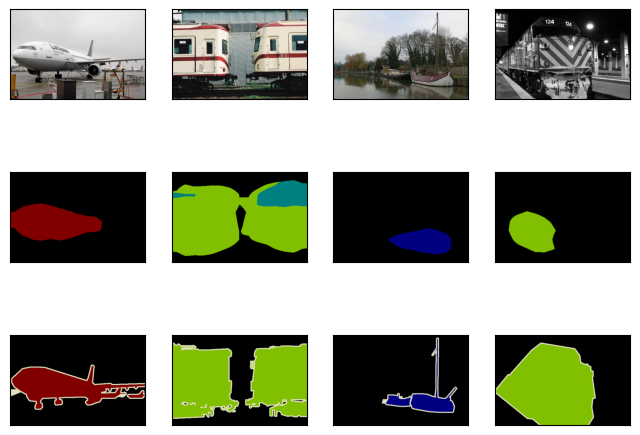

In [27]:
from utils import show_images

def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=devices)
    X = pred.long()
    return colormap[X, :]

test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs,res = 4, [], []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    res += pred
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]

show_images(imgs[::3]+imgs[1::3]+imgs[2::3], 3, n, scale=2);
    
